Structure learning:
* https://github.com/GRAND-Lab/SUBLIME
* https://github.com/swtheing/imc-gae

Imputing
* https://github.com/twitter-research/feature-propagation
* https://github.com/marblet/GCNmf

In [1]:
import os

if os.getcwd().endswith('notebook'):
    os.chdir('..')

In [2]:
import sys
sys.path

['c:\\Users\\user\\labevent\\src',
 'C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip',
 'C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python310\\DLLs',
 'C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python310\\lib',
 'C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python310',
 'c:\\Users\\user\\labevent\\.venv',
 '',
 'c:\\Users\\user\\labevent\\.venv\\lib\\site-packages',
 'c:\\Users\\user\\labevent\\.venv\\lib\\site-packages\\win32',
 'c:\\Users\\user\\labevent\\.venv\\lib\\site-packages\\win32\\lib',
 'c:\\Users\\user\\labevent\\.venv\\lib\\site-packages\\Pythonwin']

In [3]:
import sys
if not os.path.exists('libs'):
    !mkdir src/libs
gits = {
    'src/libs/gcnmf': 'https://github.com/marblet/GCNmf',
    'src/libs/imc-gae': 'https://github.com/swtheing/imc-gae',
    'src/libs/sublime': 'https://github.com/GRAND-Lab/SUBLIME',
    'src/libs/fp': 'https://github.com/twitter-research/feature-propagation'
}
for git in gits:
    if not os.path.exists(git):
        # !git submodule add {gits[git]} {git}
        sys.path.append(git)
        !git clone {gits[git]} {git}

sys.path.append(r".venv\Lib\site-packages")

torch==1.10.2
pyg==2.0.3

libs/fp - homophily experiment on synthetic data
libs/fp/src/baselines/gcn_mp.py - GCNmf

optuna
tqdm

libs/gcnmf

In [4]:
from pandas import read_csv
from sklearn.preprocessing import RobustScaler
from pandas import DataFrame

data = read_csv(r'data\refined\wide\blood_chemistry_17.csv', index_col=(0, 1),)
target_cols = ['Potassium',
                                     'Sodium', 'Creatinine', 'Chloride', 'Urea Nitrogen', 'Bicarbonate',
                                     'Anion Gap', 'Glucose', 'Magnesium', 
                                     'Calcium, Total', 'Phosphate']

scaler = RobustScaler()
data = DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)


C:\Users\user\AppData\Local\Temp\ipykernel_26856\4015295820.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  from pandas import read_csv


In [5]:
from initializer import KNNInit, FeatureCliqueInit, RandomInit
from missing_sampler import UniformMissing
from torch.nn import MSELoss
from pipeline import Pipeline
import matplotlib.pyplot as plt 
import seaborn as sns

In [6]:
from torch_geometric.utils import to_networkx
from networkx import number_connected_components, from_pandas_edgelist

knns = list(range(2, 20))
ncs = []
for knn in tqdm(knns):
    G = from_pandas_edgelist(DataFrame(KNNInit(data.values, n_neighbors=knn, mode='connectivity').edgelist.t(), columns=['source', 'target']))
    ncs.append(number_connected_components(G))


NameError: name 'tqdm' is not defined

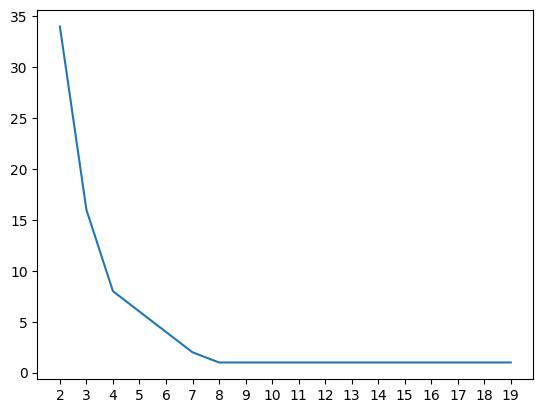

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(knns, ncs)
plt.title('Разбиение графа')
plt.xlabel('количество соседей')
plt.ylabel('количество компонент')
plt.xticks(knns);


In [ ]:
data.sample()

,,allinref,age,charttime,time_cluster,Potassium,Sodium,Creatinine,Chloride,Urea Nitrogen,Bicarbonate,...,Glucose,Magnesium,"Calcium, Total",Phosphate,race_BLACK,race_HISPANIC,race_UNKNOWN,race_WHITE,gender_F,gender_M
subject_id,specimen_id,,,,,,,,,,,,,,,,,,,,,
10029291,64490910,0.0,-0.578947,-1.046664,3.0,0.5,0.571429,0.416667,0.25,0.538462,0.0,...,0.40625,0.0,1.0,0.6,0.0,0.0,0.0,0.0,1.0,-1.0


In [7]:
from misc import discretize
from loss import SeparableMSE
def evaluate(knns, gds, ns, droprate=0.3):
    res = {}

    ppl = Pipeline()
    ppl.set_sampler(UniformMissing(data, droprate=.3, target_cols=target_cols))
    ppl.initialize(FeatureCliqueInit(division_factor=5, cols2disc=[1,], column_indices=[1, 3, -1], discretize_func=discretize))
    ppl.set_loss_func(MSELoss())
    res['age5clique'] = ppl.eval(data, 20, n_iterations=3)
    
    for n in ns:
        for knn in knns:
            ppl = Pipeline()
            ppl.initialize(KNNInit(n_neighbors=knn, mode='connectivity'))
            ppl.set_sampler(UniformMissing(data, target_cols=target_cols, droprate=droprate))
            ppl.set_loss_func(SeparableMSE())
            res[f'knn{knn}_it{n}'] = ppl.eval(data, 20, n_iterations=n)
        for gd in gds:
            ppl = Pipeline()
            ppl.set_sampler(UniformMissing(data, droprate=droprate, target_cols=target_cols))
            ppl.initialize(RandomInit(random_graph='erdos_renyi', edge_prob=gd))
            ppl.set_loss_func(SeparableMSE())
            res[f'rand{gd}_it{n}'] = ppl.eval(data, 20, n_iterations=n)

    

    ppl = Pipeline()
    ppl.set_sampler(UniformMissing(data, droprate=.3, target_cols=target_cols))
    ppl.initialize(KNNInit(n_neighbors=5, mode='connectivity'))
    ppl.set_loss_func(SeparableMSE())
    res['knn5_it0'] = ppl.eval(data, 20, n_iterations=0)

    ppl = Pipeline()
    ppl.set_sampler(UniformMissing(data, droprate=.3, target_cols=target_cols))
    ppl.initialize(RandomInit(random_graph='erdos_renyi', edge_prob=gd))
    ppl.set_loss_func(SeparableMSE())
    res['nofp+rand'] = ppl.eval(data, 20, n_iterations=0)
    
    return res
            
        

In [8]:
knns = [3, 4, 5, 6, 8]
gds = [0.05, .01, .1, .5]
ns = [1, 2, 4, 8]
res03 = evaluate(knns, gds, ns)

  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\user\labevent\src\misc.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       (-0.684, -0.211]
1       (-0.684, -0.211]
2       (-0.684, -0.211]
3       (-0.684, -0.211]
4       (-0.684, -0.211]
              ...       
2080     (-0.211, 0.158]
2081     (-0.211, 0.158]
2082     (-0.211, 0.158]
2083     (-0.211, 0.158]
2084     (-0.211, 0.158]
Name: 1, Length: 2085, dtype: category
Categories (5, interval[float64, right]): [(-2.106, -0.684] < (-0.684, -0.211] < (-0.211, 0.158] < (0.158, 0.579] < (0.579, 1.579]]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  data.iloc[:, cols2disc] = data.iloc[:, cols2disc].apply(discretize_func, **disc_kwargs)
c:\Users\user\labevent\src\misc.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to

In [9]:
res03

{'age5clique': [0.8070320456699925,
  0.8587248469068095,
  0.8432380656627689,
  0.8562857044186896,
  0.8454382301954497,
  0.8747509949517926,
  0.8494996343906247,
  0.9189348518882902,
  0.9972002363202386,
  0.8847226773881892,
  0.8831038398386539,
  0.9279443003230041,
  0.887921636984383,
  0.8763874063508511,
  0.8470138575692419,
  0.9257119906034496,
  0.9570622658329431,
  0.9780016099324458,
  0.9157490124970878,
  0.9881854325271209],
 'knn3_it1': [0.950470027900516,
  0.9875945777631635,
  0.9021069908501859,
  0.8884173216100457,
  0.88973149821486,
  0.9118625464758641,
  0.9184353683618113,
  0.903979665109964,
  0.8792909839889368,
  0.9191968894581397,
  0.9153063180691885,
  0.9085178205548156,
  0.9034669217373079,
  0.9161731281834316,
  0.9664887414044444,
  0.8774321665909897,
  0.9159308204660369,
  0.8773651853825373,
  0.885730199283908,
  0.8913118267655623],
 'knn4_it1': [0.834626827570371,
  0.9112373549920807,
  0.8759123757653414,
  0.8766582719289606,

<Axes: >

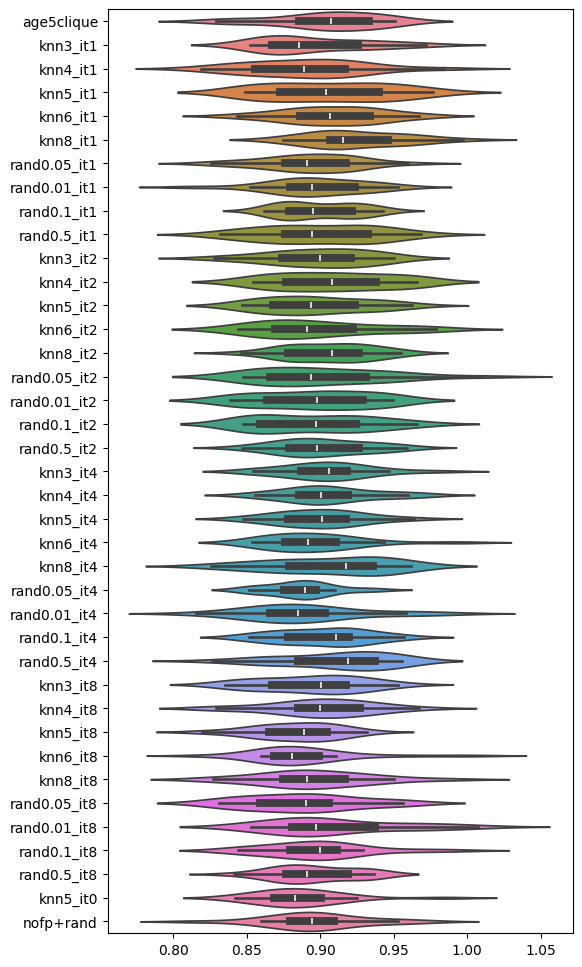

In [50]:
plt.figure(figsize=(6, 12))
sns.violinplot(res03, orient='h')

In [51]:
def meanstd(res):
    tmp = DataFrame(res)
    tmp = DataFrame({'mean': tmp.mean(), 'std': tmp.std()}, index=tmp.columns)
    return tmp

In [52]:
meanstd(res03)

,mean,std
age5clique,0.903896,0.035499
knn3_it1,0.896069,0.036282
knn4_it1,0.890888,0.040347
knn5_it1,0.906596,0.041543
knn6_it1,0.908522,0.033436
knn8_it1,0.925024,0.032875
rand0.05_it1,0.893257,0.032447
rand0.01_it1,0.896085,0.032968
rand0.1_it1,0.899512,0.025483
rand0.5_it1,0.899719,0.038827


In [ ]:
res07 = evaluate(knns, gds, ns, 0.7)

In [54]:
meanstd(res07)

,mean,std
age5clique,0.903083,0.048479
knn3_it1,0.901831,0.015832
knn4_it1,0.904763,0.010996
knn5_it1,0.904648,0.009541
knn6_it1,0.896755,0.020755
knn8_it1,0.899988,0.014482
rand0.05_it1,0.904586,0.013222
rand0.01_it1,0.902598,0.015855
rand0.1_it1,0.895470,0.016924
rand0.5_it1,0.901322,0.016114


<Axes: >

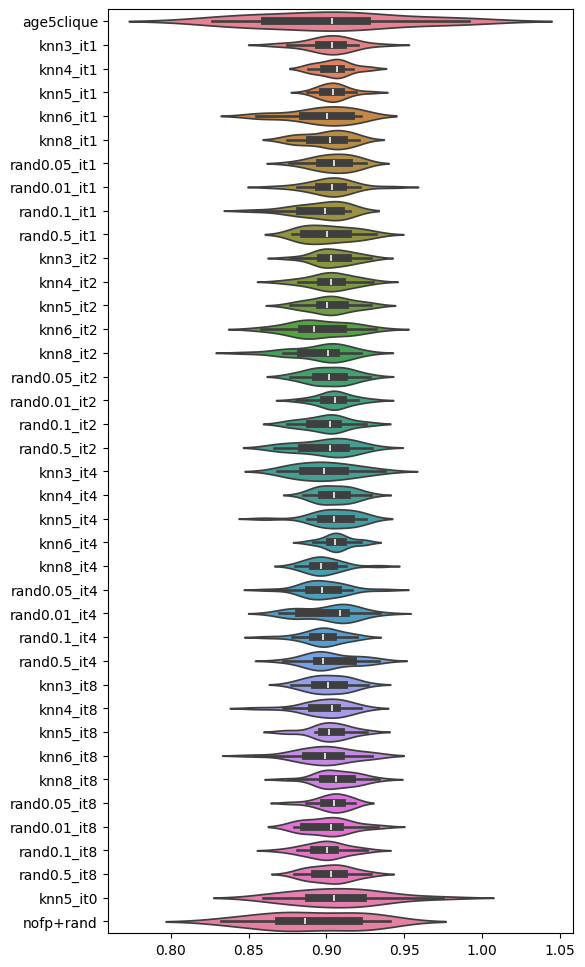

In [55]:
plt.figure(figsize=(6, 12))
sns.violinplot(res07, orient='h')

In [ ]:
res09 = evaluate(knns, gds, ns, 0.9)

<Axes: >

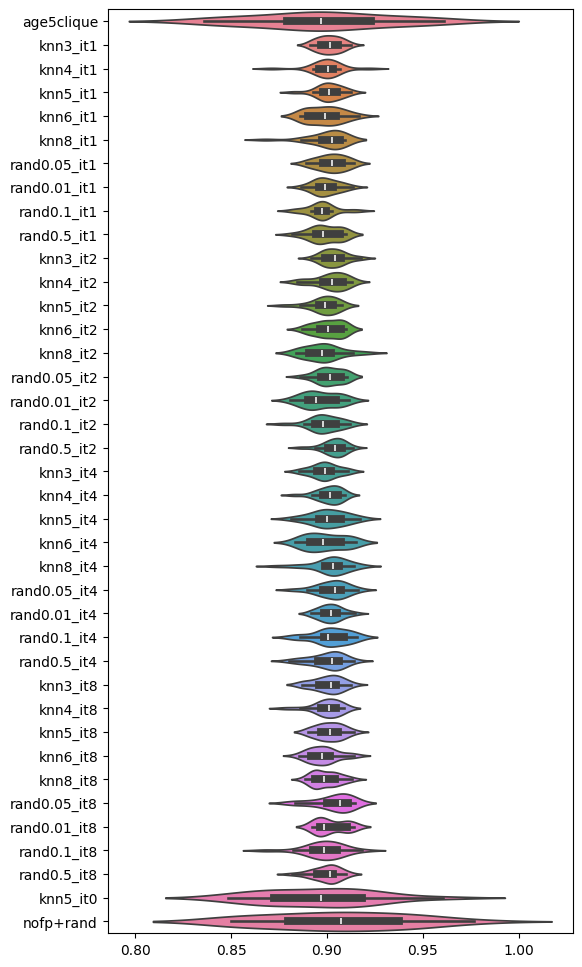

In [57]:
plt.figure(figsize=(6, 12))
sns.violinplot(res09, orient='h')

In [59]:
meanstd(res09)

,mean,std
age5clique,0.897495,0.035528
knn3_it1,0.901096,0.006051
knn4_it1,0.899533,0.009147
knn5_it1,0.901057,0.006808
knn6_it1,0.898777,0.008989
knn8_it1,0.899780,0.010075
rand0.05_it1,0.902315,0.007311
rand0.01_it1,0.899465,0.006766
rand0.1_it1,0.897288,0.007709
rand0.5_it1,0.898926,0.007920
